In [1]:
!pip install selenium
!pip install pymystem3

In [2]:
import numpy as np
import pandas as pd
import requests
from time import sleep, time
from random import randint
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import FirefoxOptions
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from pymystem3 import Mystem

# prepare


* 'Общество/Россия' : 0 - рбк(общество)/лента(россия)
* 'Экономика' : 1 - рбк/лента
* 'Силовые структуры' : 2  - лента
* 'Бывший СССР' : 3 - лента
* 'Спорт' : 4 - лента, фонтанка
* 'Забота о себе' : 5 - лента
* 'Строительство' : 6 - фонтанка
* 'Туризм/Путешествия' : 7 - лента/фонтанка
* 'Наука и техника' : 8 - лента

In [3]:
def working_time(start_time):
    t = int((time() - start_time) // 1)
    return '{:02d}:{:02d}:{:02d}'.format(t // 3600, t // 60 % 60, t % 60)

rbc_link = 'https://www.rbc.ru/'
lenta_link = 'https://lenta.ru/rubrics/'

rbc_topics = ['society', 'economics']
lenta_topics = ['russia', 'forces', 'ussr', 'sport', 'wellness', 'travel', 'science']
fontanka_topics = ['stroy', 'sport', 'turizm']

topic_index = {
    'society' : 0, 'russia': 0, 'Россия': 0,
    'economics' : 1, 'Экономика': 1,
    'forces': 2, 'Силовые структуры': 2,
    'ussr' : 3, 'Бывший СССР': 3,
    'sport' : 4, 'Спорт': 4,
    'wellness' : 5, 'Забота о себе': 5,
    'stroy': 6,
    'travel': 7, 'turizm': 7, 'Путешествия': 7,
    'science': 8, 'Наука и техника': 8
}

error_links = []

In [4]:
kaggle_df = pd.read_csv('test_news.csv')
kaggle_df

,content
0,Фото: «Фонтанка.ру»ПоделитьсяЭкс-министру обор...
1,В начале февраля 2023 года в Пушкинском районе...
2,Фото: Andy Bao / Getty Images Анастасия Борисо...
3,"Если вы хотели, но так и не съездили на море л..."
4,Сергей Пиняев Фото: Алексей Филиппов / РИА Нов...
...,...
26270,Фото: РИА Новости Алевтина Запольская Главное ...
26271,Вадим Гутцайт Фото: Sergei CHUZAVKOV / Europea...
26272,Фото: Олег Харсеев / Коммерсантъ Александр Кур...
26273,Владимир Зеленский Фото: Yves Herman / Reuters...


# parsing

## rbc parse

In [ ]:
def create_webdriver():
    opts = FirefoxOptions()
    opts.add_argument('--headless')
    return webdriver.Firefox(options=opts)

In [ ]:
def scroll_page(link):
    driver = create_webdriver()
    driver.get(link)
    scroll_pause = 0.2
    last_height = driver.execute_script("return document.body.scrollHeight")
    while last_height < 33474:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        sleep(scroll_pause)
        new_height = driver.execute_script("return document.body.scrollHeight")
        print(new_height)
        last_height = new_height
    return driver.page_source

In [ ]:
def get_text_from_article(link):
    request = requests.get(link)
    tree = BeautifulSoup(request.content)
    div_with_text = tree.body.find_all('div', attrs = {'class': 'l-window'})[1].find('div').find('div').find('div').find('div', attrs = {'class': 'js-rbcslider'}).find('div').find('div', attrs={'class': "article g-relative js-rbcslider-article"}).find('div').find('div').find('div', attrs={'class': 'article__text'})
    for i in div_with_text.select('div'):
        i.decompose()
    raw_text = div_with_text.find_all('p')
    return '\n'.join([p.text for p in raw_text])

In [ ]:
def rbc_get_topics_links(news):
    links = []
    for post in news:
        links.append(post.find('div', attrs = {'class': 'item__wrap'}).a.get('href'))
    return links

In [ ]:
start_time = time()

for topic in rbc_topics:
    response = scroll_page(rbc_link + topic)
    tree = BeautifulSoup(response)
    news = tree.body.find_all('div', attrs = {'class': 'l-window'})[1].find('div', attrs = {'class': 'g-relative g-clear'}).find('div', attrs = {'class': 'l-col-container'}).find('div', attrs = {'class': 'l-table'}).find('div', attrs = {'class': 'g-relative'}).find('div', attrs = {'class': 'l-table'}).find('main').find('div', attrs = {'class': 'g-overflow'}).find('div', attrs = {'class': 'l-row'}).find_all('div', attrs = {'class': 'item'})
    print(len(news))
    print('end time is', time() - start_time)
    for i, link in enumerate(rbc_get_topics_links(news)):
        print(f'{i} link of {topic}')
        text = get_text_from_article(link)
        X_train = X_train._append({'content': text}, ignore_index=True)
        y_train = y_train._append({'topic': topic_index[topic]}, ignore_index=True)

In [ ]:
X_train.to_csv('rbc_X.csv', index=False)
y_train.to_csv('rbc_y.csv', index=False)

## lenta parse

In [ ]:
X_train = pd.DataFrame()
y_train = pd.DataFrame()

In [ ]:
def lenta_get_topics_links(news):
    links = []
    for post in news:
        links.append(post.find('div', attrs = {'class': 'item__wrap'}).a.get('href'))
    return links

In [ ]:
def get_topic_links(tree):
    raw_topics = tree.body \
    .find('div', attrs={'class': 'layout js-layout'}) \
    .find('div', attrs={'class': 'layout__container'}) \
    .main \
    .find('div', attrs={'class': 'rubric-page'}) \
    .find('div', attrs={'class': 'rubric-header'}) \
    .find('div', attrs={'rubric-header__container'}) \
    .find_all('a')[1:]
    return ['https://lenta.ru' + raw_topic.get('href') for raw_topic in raw_topics]


In [ ]:
def get_article_link(tree):
    raw_topics = tree.body \
    .find('div', attrs={'class': 'layout js-layout'}) \
    .find('div', attrs={'class': 'layout__container'}) \
    .main \
    .find('div', attrs={'class': 'rubric-page'}) \
    .find('section', attrs={'class': 'rubric-page__section'}) \
    .ul \
    .find_all('li')
    links = ['https://lenta.ru' + raw_topic.a.get('href') for raw_topic in raw_topics]
    return links

In [ ]:
def get_text(tree):
    try:
        raw_text = tree.body \
        .find('div', attrs={'class': 'layout'}) \
        .find('div', attrs={'class': 'layout__container'}) \
        .main \
        .find('div', attrs={'class': 'topic-page__wrap'}) \
        .find('div', attrs={'class': 'topic-page'}) \
        .div \
        .find('div', attrs={'class': 'topic-page__content'}) \
        .div \
        .find('div', attrs={'class': 'topic-body__content'}) \
        .find_all('p')
        text = '\n'.join([i.text for i in raw_text])
    except:
        return False
    return text


In [ ]:
def try_request(link):
    try:
        return requests.get(link)
    except:
        return False

In [ ]:
def check_response(response, mega_topic, X_train, y_train):
    if not response:
        print('skipped', mega_topic)
        return False
    if response.status_code // 100 != 2:
        print(f'error in {mega_topic}')
        return False
    return True

In [ ]:
last_add = 0
start_time = time()
c = 0



def parse_lenta(mega_topic, topic_index=topic_index, lenta_link=lenta_link, X_train=X_train, y_train=y_train, c=c, start_time=start_time, last_add=last_add):
    response = try_request(lenta_link + mega_topic)
    if not check_response(response, mega_topic, X_train, y_train):
        return [X_train, y_train]
    tree = BeautifulSoup(response.content)
    topic_links = get_topic_links(tree)
    for topic_link in topic_links:
        response = try_request(topic_link)
        if not check_response(response, mega_topic, X_train, y_train):
            continue
        tree = BeautifulSoup(response.content)
        if len(tree.find_all('img')) > 20:
            new_topic = topic_link[topic_link[:-1].rfind('/')+1:-1]
            topic_index[new_topic] = topic_index[mega_topic]
            X_train, y_train = parse_lenta(mega_topic=new_topic, X_train=X_train, y_train=y_train)
            continue
        links = get_article_link(tree)
        for i, link in enumerate(links[:-1]):
            print(i, mega_topic, topic_link, link)
            response = try_request(link)
            if not check_response(response, mega_topic, X_train, y_train):
                continue
            tree = BeautifulSoup(response.content)
            text = get_text(tree)
            if not text:
                print('skipped', 1, mega_topic, topic_link, link)
                continue
            X_train = X_train._append({'content': text}, ignore_index=True)
            y_train = y_train._append({'topic': topic_index[mega_topic]}, ignore_index=True)
            c += 1
        print(f'added {c - last_add} articles from {topic_link}!!!')
        print('pass', time() - start_time, 'sec')
        last_add = c
        X_train.to_csv('lenta_X.csv', index=False)
        y_train.to_csv('lenta_y.csv', index=False)
    return [X_train, y_train]



for mega_topic in lenta_topics:
    X_train, y_train = parse_lenta(mega_topic=mega_topic, X_train=X_train, y_train=y_train)

In [ ]:
y_train.value_counts()

topic
0        599
8        330
4        217
3        180
5        150
7        150
2        120
dtype: int64

In [ ]:
y_train[y_train['topic'] == 0]

y_train

,topic
0,0
1,0
2,0
3,0
4,0
...,...
1741,8
1742,8
1743,8
1744,8


In [ ]:
df = pd.read_csv('lenta_y.csv')

## fontanka parse


In [ ]:
data = pd.DataFrame()

In [ ]:
def get_articles(tree):
    articles = tree.find_all('li', attrs={'class': 'INaft LVa3'})
    return articles

In [ ]:
def get_articles_link(articles):
    links = [article.find('a', attrs={'class': 'INcd'}).get('href') for article in articles]
    return [link if 'http' in link else 'https://www.fontanka.ru' + link for link in links]

In [ ]:
def get_text(tree):
    try:
        return '\n'.join([p.text for p in tree.find('section', attrs={'class': 'K1an9'}).find_all('p')])
    except:
        print("can't find text")
        return ''


In [ ]:
def try_request(url, error_links):
    try:
        return requests.get(url)
    except:
        print(f"can't get response from: {url}")
        error_links.append(url)
        return False

In [ ]:
start_time = time()
save_every = 100
for topic in fontanka_topics:
    # getting links
    links = []
    for n_page in range(1, 340):
        url = f'https://www.fontanka.ru/cgi-bin/search.scgi?query=&rubric={topic}&sortt=date&fdate=2000-01-03&tdate=2024-01-15&offset={n_page}'
        response = try_request(url, error_links)
        if not response:
            continue
        tree = BeautifulSoup(response.content)
        articles = get_articles(tree)
        print(f"get {len(articles)} articles about {topic} from {n_page} page")
        if len(articles) == 0:
            print("articles not found")
            break
        links += get_articles_link(articles)
    print(f"{len(links)} links at all")
    # getting texts from links
    for i, link in enumerate(links):
        response = try_request(link, error_links)
        if not response:
            print(f"can't get response from {link}")
            continue
        tree = BeautifulSoup(response.content)
        text = get_text(tree)
        data = data._append({'content': text, 'url': link, 'topic': topic_index[topic]}, ignore_index=True)
        if i % save_every == 0:
            print("file updated successfuly")
            print(len(data))
            data.to_csv('fontanka1.csv', index=False, mode='w')

print("file updated successfuly")
print(len(data))
data.to_csv('fontanka1.csv', index=False, mode='w')
print('working time is', time() - start_time)

get 30 articles about turizm from 1 page
get 30 articles about turizm from 2 page
get 30 articles about turizm from 3 page
get 30 articles about turizm from 4 page
get 30 articles about turizm from 5 page
get 30 articles about turizm from 6 page
get 30 articles about turizm from 7 page
get 30 articles about turizm from 8 page
get 30 articles about turizm from 9 page
get 30 articles about turizm from 10 page
get 30 articles about turizm from 11 page
get 30 articles about turizm from 12 page
get 30 articles about turizm from 13 page
get 30 articles about turizm from 14 page
get 30 articles about turizm from 15 page
get 30 articles about turizm from 16 page
get 30 articles about turizm from 17 page
get 30 articles about turizm from 18 page
get 30 articles about turizm from 19 page
get 30 articles about turizm from 20 page
get 30 articles about turizm from 21 page
get 30 articles about turizm from 22 page
get 30 articles about turizm from 23 page
get 30 articles about turizm from 24 page
g

### async (don't work)

In [ ]:
import asyncio
import aiohttp

In [ ]:
data = pd.DataFrame()
def get_articles(tree):
    articles = tree.find_all('li', attrs={'class': 'H-aer KHbz'})
    return articles

def get_articles_link(articles):
    return ['https://www.fontanka.ru' + article.find('a', attrs={'class': 'H-cj'}).get('href') for article in articles]

def get_text(tree):
    return '\n'.join([p.text for p in tree.find('section', attrs={'class': 'KZam5'}).find_all('p')])

async def try_request(url, error_links):
    async with aiohttp.ClientSession() as session:
        try:
            response = await session.get(url)
            print(response)
            tree = BeautifulSoup(response.content)
            return await tree
        except:
            error_links.append(url)
            return False


In [ ]:
start_time = time()
save_every = 10
for topic in fontanka_topics[:1]:
    task = []
    for link in links:
            task = asyncio.create_task(try_request(link, error_links))
            tasks.append(task)

        await asyncio.gather(*tasks)

    for i, link in enumerate(links):
        tree = try_request(link, error_links)
        if not tree:
            continue
        # tree = BeautifulSoup(response.content)
        text = get_text(tree)
        data = data._append({'content': text, 'url': link, 'topic': topic_index[topic]}, ignore_index=True)
        if i % save_every == 0:
            data.to_csv('fontanka.csv', index=False)
print('working time is', time() - start_time)

<ClientResponse(https://www.fontanka.ru/cgi-bin/search.scgi?query=&rubric=stroy&sortt=date&fdate=2000-01-03&tdate=2024-01-15&offset=1) [200 OK]>
<CIMultiDictProxy('Server': 'ddos-guard', 'Connection': 'keep-alive', 'Keep-Alive': 'timeout=60', 'Set-Cookie': '__ddg1_=RQC7Dffr5JkgYCJTrRuw; Domain=.fontanka.ru; HttpOnly; Path=/; Expires=Thu, 16-Jan-2025 14:45:17 GMT', 'Date': 'Wed, 17 Jan 2024 14:45:17 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Set-Cookie': 'ngs_uid=wxPcFmWn5/16e60tCUqBAg==; path=/; httponly', 'Set-Cookie': 'fontanka_ab_scrooge_478_v5=B;Domain=.fontanka.ru;Path=/;Max-Age=1209600', 'Set-Cookie': 'fontanka_ab_31=A;Domain=.fontanka.ru;Path=/;Max-Age=5184000', 'Set-Cookie': 'fontanka_ab_main_page_4redesign=B;Domain=.fontanka.ru;Path=/;Max-Age=1209600', 'X-AB': 'fontanka_ab_scrooge_478_v5=B;fontanka_ab_31=A;fontanka_ab_main_page_4redesign=B', 'Set-Cookie': 'fontanka_ab_scrooge_478_v5=B;Domain=.fontanka.ru;Path=/;Max-Age=1209600', 'Set-Cookie': 'fontanka_ab_31=A;Domain=.

C:\Users\alexe\AppData\Local\Temp\ipykernel_20080\356600839.py:21: RuntimeWarning: coroutine 'StreamReader.read' was never awaited
  return False


AttributeError: 'coroutine' object has no attribute 'find_all'

# ML

## downloading

In [5]:
fontanka = pd.read_csv('fontanka.csv')
fontanka1 = pd.read_csv('fontanka1.csv')
fontanka = fontanka[fontanka['topic'] != 7]
fontanka = pd.concat([fontanka, fontanka1], ignore_index=True)
fontanka = fontanka[~fontanka['content'].isna()]
fontanka['topic'].value_counts()

topic
4    9870
6    8402
7    8015
Name: count, dtype: int64

In [6]:
lenta = pd.read_csv('lenta_ru_news_2019_2023.csv/lenta_ru_news_2019_2023.csv')

In [7]:
lenta = lenta.loc[:, ['url', 'text', 'topic']]
lenta = lenta.query("topic in ['Россия', 'Экономика', 'Силовые структуры', 'Бывший СССР', 'Спорт', 'Наука и техника', 'Путешествия', 'Забота о себе']")
lenta['topic'] = lenta['topic'].replace(topic_index)

In [8]:
lenta_with_right_cols = lenta.loc[:, ['text', 'url', 'topic']]
lenta_with_right_cols.columns = fontanka.columns
df = pd.concat([lenta_with_right_cols, fontanka], ignore_index=True)

In [9]:
df.isna().sum()

content    0
url        0
topic      0
dtype: int64

In [10]:
df['topic'].value_counts()

topic
0    96717
3    51071
1    48980
4    38312
2    30249
7    27323
8    25209
6     8402
5     7589
Name: count, dtype: int64

In [11]:
(df['topic'] != 0).astype(int)

0         0
1         0
2         1
3         0
4         0
         ..
333847    1
333848    1
333849    1
333850    1
333851    1
Name: topic, Length: 333852, dtype: int32

In [12]:
df2 = df[np.array([list((df['topic'] != 0)), [randint(1, 10) > 4 for i in range(len(df))]]).T.any(axis=1)]

In [13]:
df2.topic.value_counts()

topic
0    58066
3    51071
1    48980
4    38312
2    30249
7    27323
8    25209
6     8402
5     7589
Name: count, dtype: int64

In [14]:
X = df['content']
y = df['topic']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train.shape, X_test.shape

((300466,), (33386,))

In [16]:
X2 = df2['content']
y2 = df2['topic']

In [17]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, random_state=42, shuffle=True)

## tf-idf (best solution)

### all data

In [48]:
start_time = time()
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.80, min_df=0.0006)
tfidf.fit(X_train)

tf_idf_train = tfidf.transform(X_train)
tf_idf_test = tfidf.transform(X_test)
print(tf_idf_train.shape)
print(working_time(start_time))

(300466, 42333)
00:06:19


In [49]:
scaler = MaxAbsScaler()

scaler.fit(tf_idf_train)

normed_train = scaler.transform(tf_idf_train)
normed_test = scaler.transform(tf_idf_test)

In [50]:
start_time = time()
lr_tf_idf = LogisticRegression(max_iter=300)
lr_tf_idf.fit(normed_train, y_train)

lr_train_pred = lr_tf_idf.predict(normed_train)
lr_test_pred = lr_tf_idf.predict(normed_test)

print(accuracy_score(y_train, lr_train_pred), accuracy_score(y_test, lr_test_pred))
print(working_time(start_time))

D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9912835395685369 0.9260767986581202
00:05:05


### data without 40% of 0 topic

In [80]:
start_time = time()
tfidf2 = TfidfVectorizer(ngram_range=(1, 2), max_df=0.80, min_df=0.0003)
tfidf2.fit(X_train2)

tf_idf_train2 = tfidf2.transform(X_train2)
tf_idf_test2 = tfidf2.transform(X_test2)
print(tf_idf_train2.shape)
print(working_time(start_time))

(265517, 81266)
00:03:47


In [89]:
scaler2 = MaxAbsScaler()

scaler2.fit(tf_idf_train2)

normed_train2 = scaler2.transform(tf_idf_train2)
normed_test2 = scaler2.transform(tf_idf_test2)
normed_train2 = tf_idf_train2
normed_test2 = tf_idf_test2

In [90]:
start_time = time()
lr_tf_idf2 = LogisticRegression(max_iter=400, n_jobs=-1)
lr_tf_idf2.fit(normed_train2, y_train2)

lr_train_pred2 = lr_tf_idf2.predict(normed_train2)
lr_test_pred2 = lr_tf_idf2.predict(normed_test2)

print(accuracy_score(y_train2, lr_train_pred2), accuracy_score(y_test2, lr_test_pred2))
print(working_time(start_time))

0.95740009114294 0.9345129143786862
00:11:01


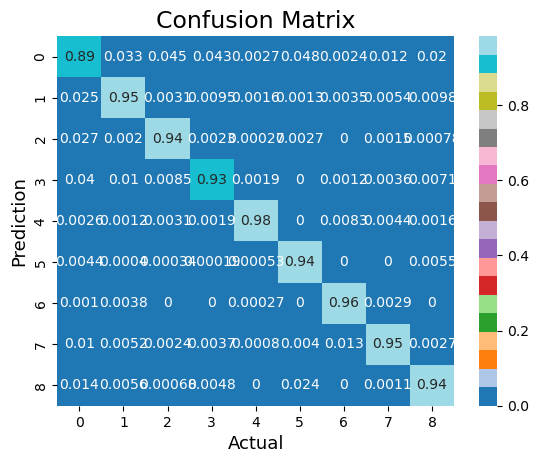

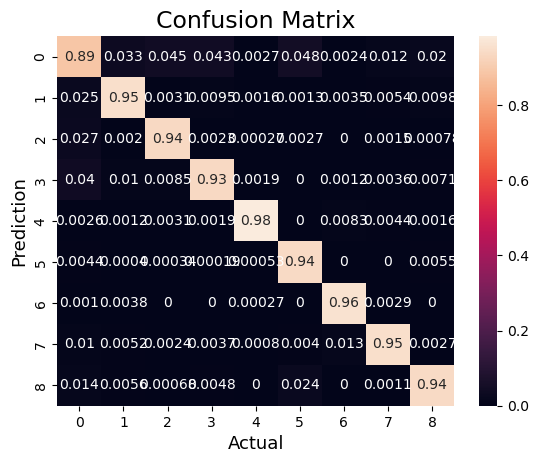

In [86]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test2, lr_test_pred2)
cm_normed = cm / cm.sum(axis=1)

sns.heatmap(cm_normed,
			annot=True,
            cmap = "tab20"
           )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


sns.heatmap(cm_normed,
			annot=True
           )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

### send to kaggle

In [76]:
tf_idf_test2 = tfidf2.transform(kaggle_df.content)
normed_test2 = scaler2.transform(tf_idf_test2)
lr_test_pred2 = lr_tf_idf2.predict(normed_test2)

In [77]:
res_df = pd.DataFrame(np.array([lr_test_pred2, np.arange(lr_test_pred2.size)]).T)

In [78]:
res_df.columns = ['topic', 'index']

In [79]:
res_df.to_csv('tf-idf_lr_scaler_9349.csv', index=False)

## CountVectorizer

In [39]:
start_time = time()
vectorizer = CountVectorizer(max_df=0.7, min_df=0.004)

X_vec_train = vectorizer.fit_transform(X_train2).toarray()
X_vec_test = vectorizer.transform(X_test).toarray()

print(working_time(start_time), X_vec_train.shape, X_vec_test.shape)

00:01:25 (236015, 4982) (66771, 4982)


In [41]:
start_time = time()
lr_cv = LogisticRegression(max_iter=100)
lr_cv.fit(X_vec_train, y_train2)

lr_train_pred = lr_cv.predict(X_vec_train)
lr_test_pred = lr_cv.predict(X_vec_test)

print(accuracy_score(y_train2, lr_train_pred), accuracy_score(y_test, lr_test_pred))
print(working_time(start_time))

D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9426222909560833 0.9236195354270567
00:08:37
